# Gyroscope DDPG reward function testing (spinup library)

In [1]:
# test iter2_base and print all the unsteady states

In [2]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

## Plot rewards

In [3]:
def read_progress(agent_path):
    
    # count lines
    file = open(agent_path+"/progress.txt", "r")
    count = len(file.readlines())
    data = np.empty([count-1, 19])
    file.seek(0)
    
    # read each line as a numpy array
    for row, x in enumerate(file):
        if row == 0:
            continue
        data[row-1] = np.array(x.split('\t')).astype(np.float)
    file.close()
    
    return data

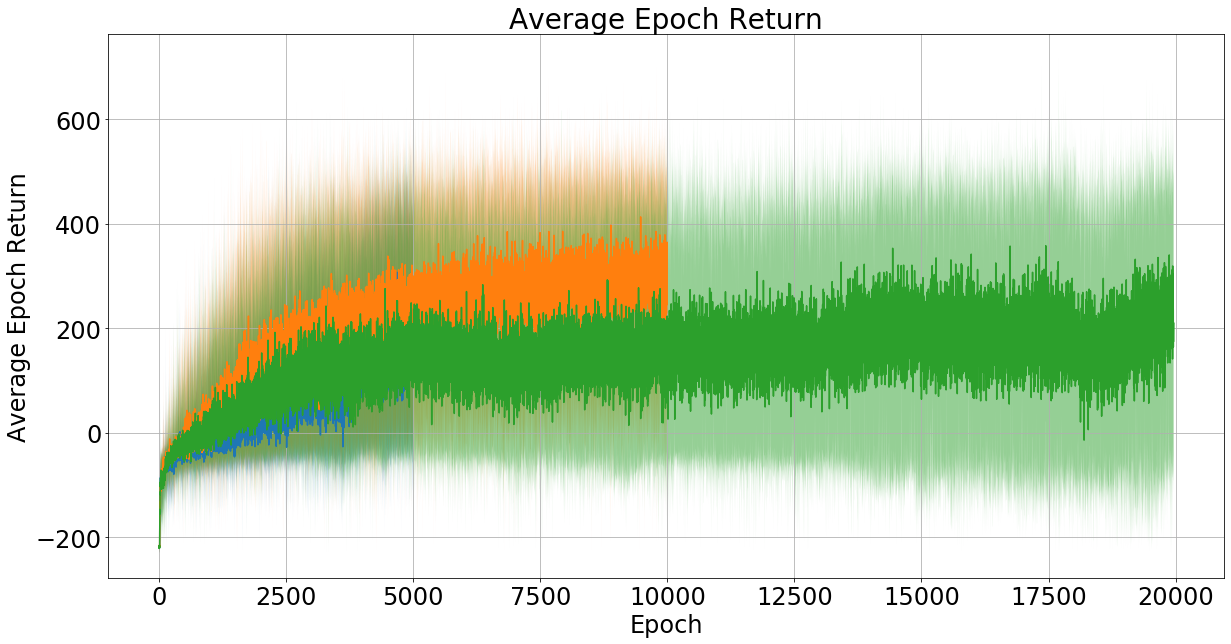

In [103]:
plt.figure(figsize=(20,10))
plt.title('Average Epoch Return',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Epoch Return',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

agent_paths = ['iter2_base','iter2_reward01','iter2_reward02','iter2_reward03','iter2_reward04',
              'iter2_gamma01','iter2_gamma02','iter2_lr01','iter2_lr02',
              'iter2_noise01','iter2_noise02','iter2_noise03','iter2_noise04']

agent_paths = ['iter2_final_5k','iter2_final_10k','iter2_final']

for agent_path in agent_paths[:]:
    progress = read_progress(agent_path)
#     print(agent_path, len(progress))
    plt.plot(np.arange(progress.shape[0]), progress[:,1])
    plt.fill_between(np.arange(progress.shape[0]), progress[:,3], progress[:,4], alpha=0.5)
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,1]+progress[:,2], progress[:,1]-progress[:,2], alpha=0.5)

# plt.xlim([0,500])
# plt.ylim([-2000,0])
# plt.legend(agent_paths,fontsize=24)

## Test an agent

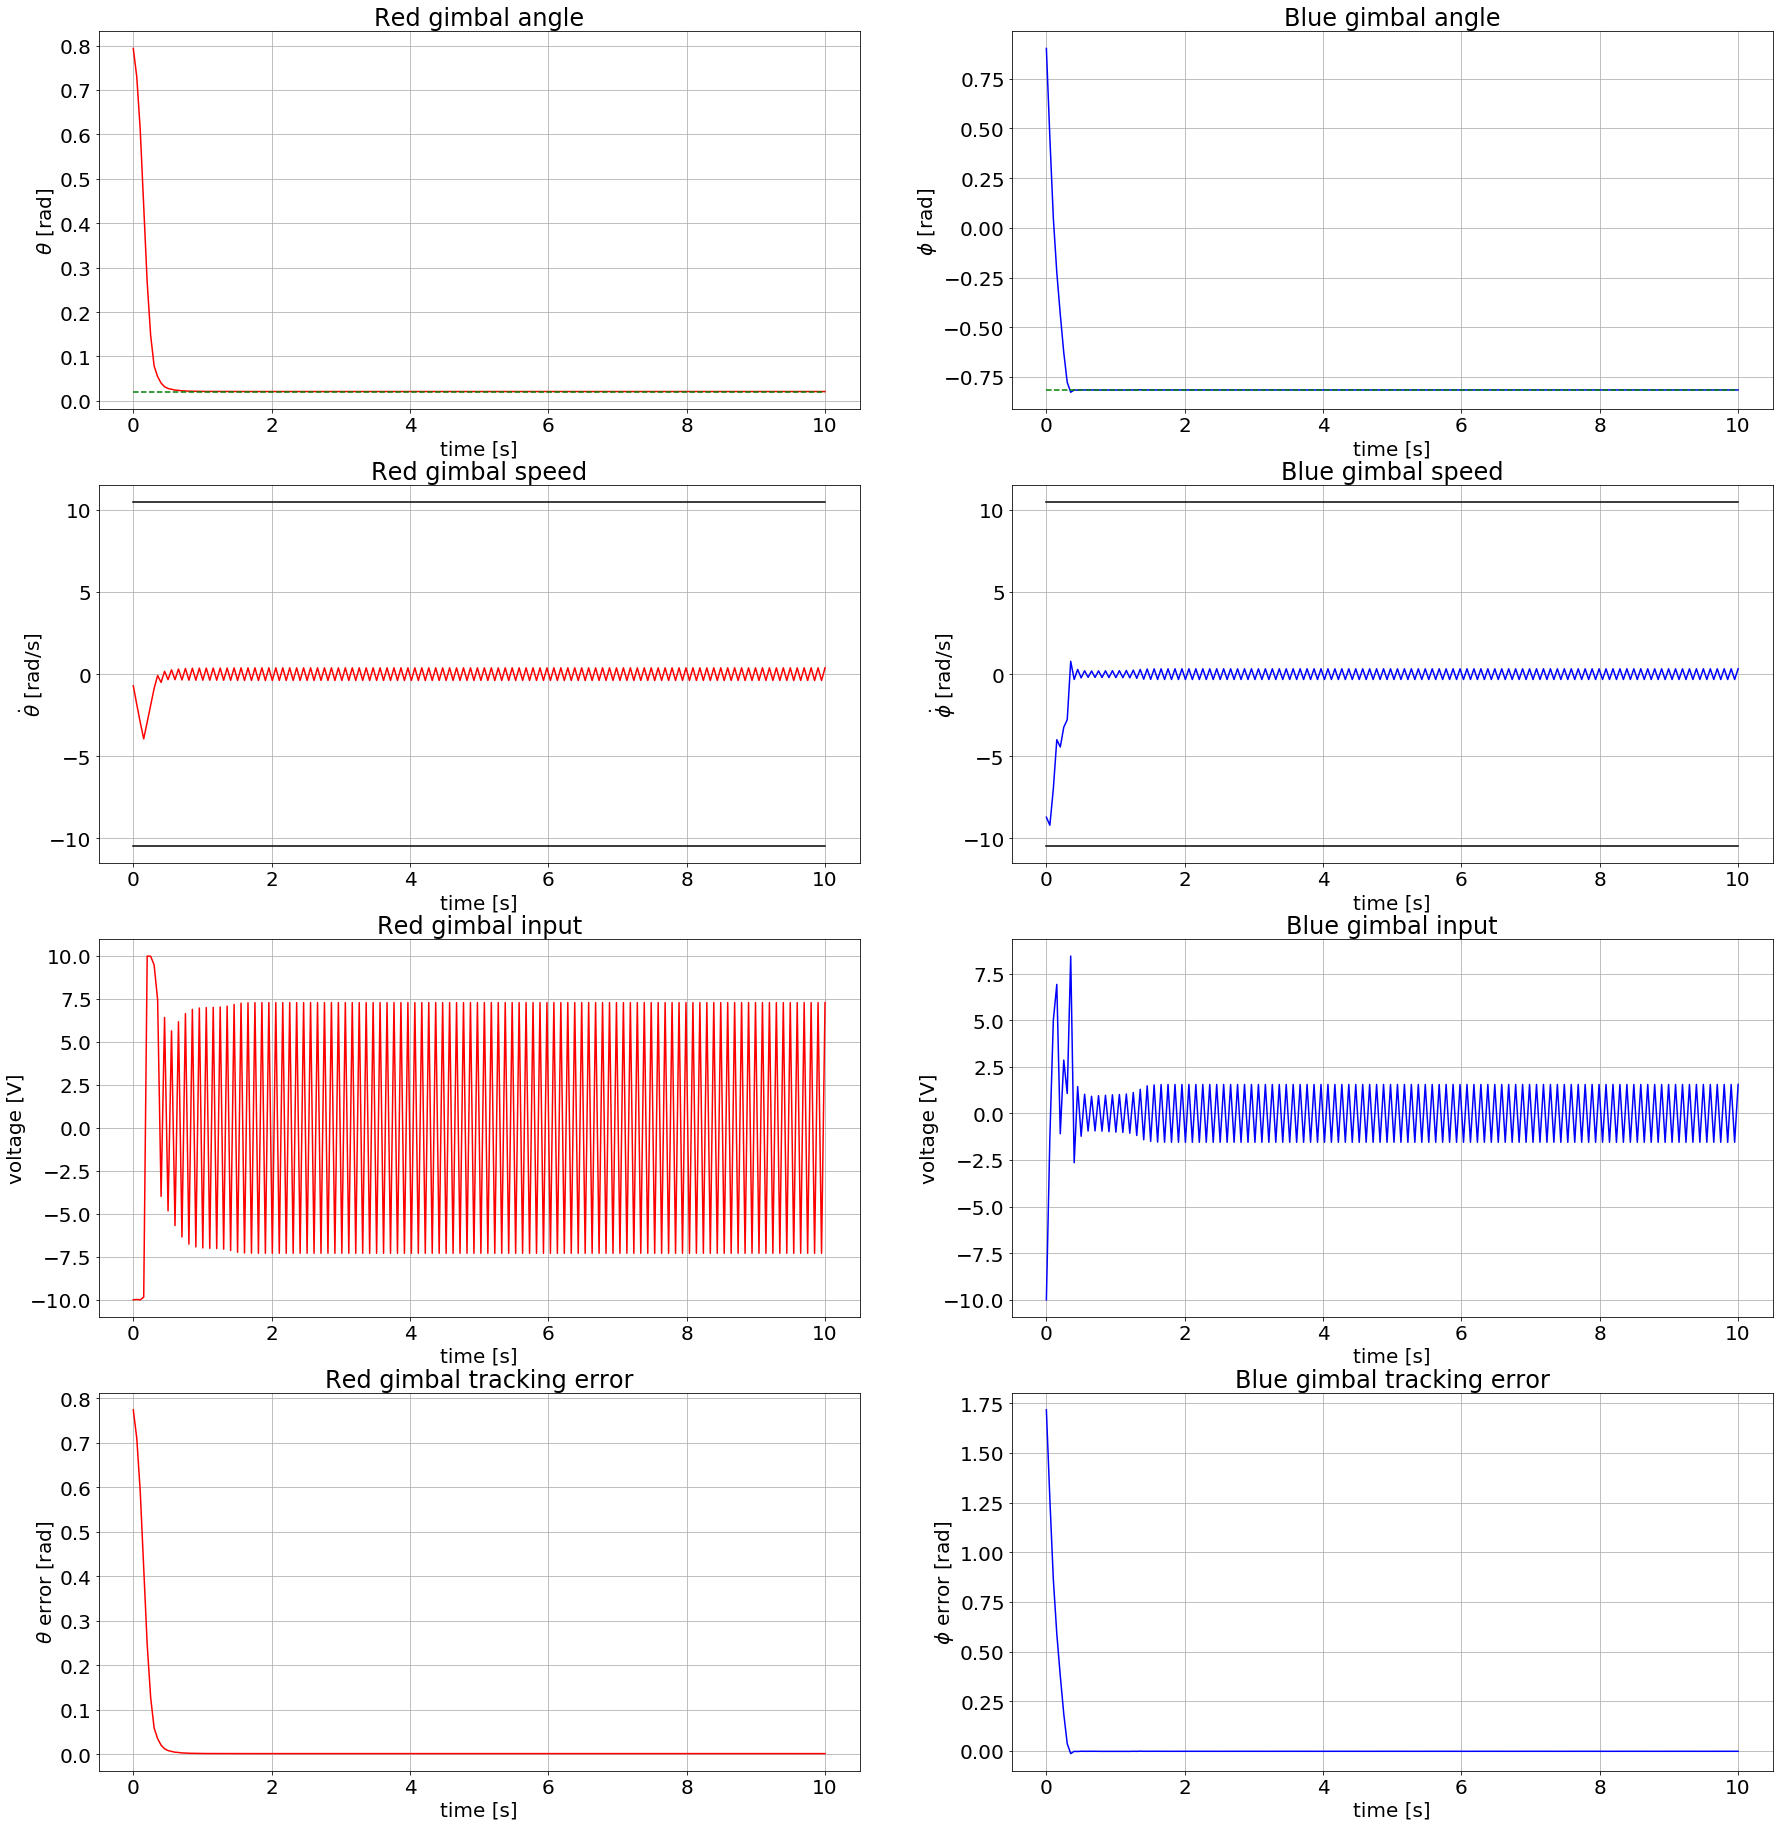

In [98]:
# Test paramaters
env_name = 'GyroscopeEnv-v1'
simu_args = {
    'dt': 0.05,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Sparse with exp'
reward_args = {
    'qx1': 1, 
    'qx2': 0, 
    'qx3': 1, 
    'qx4': 0, 
    'pu1': 0, 
    'pu2': 0,
    'e': 10,
    'bound': 0.001,
    'reward': 10
}

# init_state = np.array([0,0,0,0,200/60*2*np.pi,45/180*np.pi,-60/180*np.pi])
env = create_env(env_name,simu_args,reward_func,reward_args,state=None)

agent_paths = ['iter2_base','iter2_reward01','iter2_reward02','iter2_reward03','iter2_reward04',
              'iter2_gamma01','iter2_gamma02','iter2_lr01','iter2_lr02',
              'iter2_noise01','iter2_noise02','iter2_noise03','iter2_noise04']

agent_paths = ['iter2_final']

agent = load_agent(agent_paths[0])
t_end = 10

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)

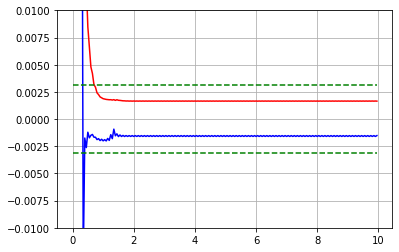

In [99]:
time = np.arange(0,10,0.05)
plt.plot(time, env.angle_normalize(state_record[:,0] - state_record[:,4]),'r')
plt.plot(time, env.angle_normalize(state_record[:,2] - state_record[:,5]),'b')
plt.plot(time, [np.pi/1000]*len(time), 'g--')
plt.plot(time, [-np.pi/1000]*len(time), 'g--')
plt.ylim([-0.01,0.01])
plt.grid()

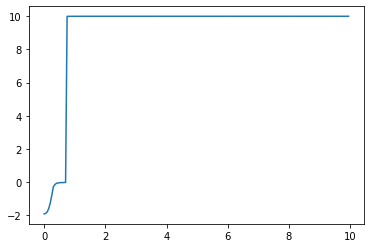

In [100]:
plt.plot(time, reward_record)

## Evaluate control performance

In [149]:
iter2_metrics = pd.read_csv('iter2_metrics.csv')
pd.set_option('display.max_columns', None)
iter2_metrics

,Unnamed: 0,iter2_base_new,iter2_reward01,iter2_reward02,iter2_reward03,iter2_reward04,iter2_gamma01,iter2_gamma02,iter2_lr01,iter2_lr02,iter2_noise01,iter2_noise02,iter2_noise03,iter2_noise04
0,$\theta$ MAE (rad),0.0842,0.0862,0.1028,0.0970,0.0904,0.0858,0.0906,0.0844,0.0881,0.0963,0.0891,0.0874,0.0893
1,$\phi$ MAE (rad),0.0709,0.0696,0.0829,0.0718,0.0724,0.0737,0.0667,0.0866,0.0711,0.0799,0.0732,0.0816,0.0649
2,$\theta$ MSSE (rad),0.0059,0.0048,0.0168,0.0147,0.0134,0.0056,0.0094,0.0069,0.0120,0.0116,0.0079,0.0081,0.0088
3,$\phi$ MSSE (rad),0.0114,0.0107,0.0130,0.0144,0.0086,0.0064,0.0098,0.0231,0.0062,0.0129,0.0099,0.0145,0.0094
4,$\theta$ in bounds (%),99.9100,99.8700,99.4600,99.7900,99.7600,99.8400,99.7100,99.9200,99.8400,99.6600,99.8200,99.8800,99.6800
5,$\phi$ in bounds (%),99.9200,99.8300,99.4300,99.2600,99.7600,99.8900,99.6300,98.3900,99.9100,98.9100,99.7200,99.8100,99.8100
6,$\theta$ unsteady (%),0.0000,0.0500,0.1500,0.0800,0.1100,0.0600,0.0900,0.0700,0.0300,0.1700,0.0800,0.0100,0.1500
7,$\phi$ unsteady (%),0.0600,0.1200,0.2900,0.2500,0.1400,0.0700,0.2400,0.2300,0.0400,0.7900,0.1300,0.0500,0.1500
8,$\theta$ rise time (s),0.4680,0.4825,0.5460,0.5095,0.4970,0.4695,0.4890,0.4556,0.4683,0.5255,0.4675,0.4632,0.4748
9,$\phi$ rise time (s),0.3314,0.3201,0.3725,0.3204,0.3409,0.3574,0.3051,0.3268,0.3484,0.3394,0.3386,0.3588,0.3087


In [ ]:
iter2_final_metrics = pd.read_csv('iter2_final_metrics.csv')
pd.set_option('display.max_columns', None)
iter2_final_metrics

In [148]:
# iter2_metrics = pd.read_csv('iter2_base_metrics.csv')

# agent_paths = ['iter2_base','iter2_reward01','iter2_reward02','iter2_reward03','iter2_reward04',
#               'iter2_gamma01','iter2_gamma02','iter2_lr01','iter2_lr02',
#               'iter2_noise01','iter2_noise02','iter2_noise03','iter2_noise04']

# for ap in agent_paths[1:]:
#     fp = ap + '_metrics.csv'
#     try:
#         m = pd.read_csv(fp)
#         iter2_metrics = pd.concat([iter2_metrics, m.iloc[:,1]],axis=1)
#     except FileNotFoundError:
#         print(fp)
# iter2_metrics = iter2_metrics.round(4)
# iter2_metrics.to_csv('iter2_metrics.csv',index=False)
# iter2_metrics

In [55]:
# Print unsteady states in the test set

In [54]:
# Env
env_name = 'GyroscopeEnv-v1'
env = create_env(env_name)

# num and set
num_test = 10000
states = np.genfromtxt('states10k.csv', delimiter=',')

# Init dataframe
agent_path = 'iter2_final'
t_end = 10
ss_bound = 0.25

agent = load_agent(agent_path)
metrics = evaluate_control(env,agent,agent_path,t_end,ss_bound,num_test,states,print_unsteady=True)

[-2.68501925  7.01087952  2.96973443 -1.5429709  -1.35374928 -2.0526638
 29.2301178 ]
[-0.90358025 -2.80121922  1.55162334 -4.25805426 -1.79570782 -2.0033257
 28.21135139]
[ 3.0589664  10.063694    1.02423525 -5.71295404 -0.62516499 -1.15860951
 28.03705788]
[  1.37525475  10.26818943  -0.80894679 -10.10875893   0.9309392
  -1.71592414  14.31463623]
[-2.65660524 -3.7292614   2.07513547  8.76141071 -0.44219136 -1.74097681
 16.75682831]
[ -2.68821502  -3.69432163   2.15117145   2.85812259   2.95249891
  -3.13310456 -11.89122486]
[-2.89386868  9.29142189  0.54912627 -5.9650054  -0.34469631 -1.71993828
 22.27171135]
[-2.83473969  3.18959928  1.33038032  8.26639366 -0.73311478 -1.68474627
 30.55872345]
[ 2.2098186  -1.04514945 -2.91522551 -0.87299228  2.46146393 -1.75419462
 14.57072067]
[ 1.94742775 10.34508228  1.45756149  2.16368747  2.0488131  -3.14156413
 29.60562515]
[  2.36828971   6.52641678   1.37906313   1.51059461  -1.67440164
  -1.61385548 -14.46282101]
[ 1.5635246   0.66064143 